In [1]:
!pip install -q -U transformers num2words qformer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.1/41.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 95.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 617.4/617.4 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━

# Library code, modified

In [6]:
import torch


def mask_top_right_quadrant(tensor):
    """
    Masks the top right quadrant of a tensor.

    Args:
        tensor (Tensor): The input tensor.

    Returns:
        Tensor: The masked tensor.
    """
    rows, cols = tensor.shape[-2:]
    mask = torch.ones(rows, cols).to("cuda:0")
    mask[: rows // 2, cols // 2 :] = 0
    tensor=tensor.to("cuda:0")
    return tensor * mask

In [8]:
from einops import rearrange, reduce
from torch import Tensor, nn
from zeta.nn import (
    MultiQueryAttention,
    SimpleFeedForward,
)
from zeta.nn.attention.cross_attention import CrossAttention


def img_to_text(x: Tensor, seqlen: int, dim: int, norm: bool = True):
    """
    Convert an image tensor to a text tensor.

    Args:
        x (Tensor): Input image tensor of shape (batch_size, channels, height, width).
        seqlen (int): Length of the output text sequence.
        dim (int): Dimension of the intermediate representation.
        norm (bool, optional): Whether to apply layer normalization. Defaults to True.

    Returns:
        Tensor: Output text tensor of shape (batch_size, seqlen, dim).

    Example::
        >>> x = torch.randn(2, 3, 32, 32)
        >>> x = img_to_text(x, 100, 512)
        >>> x.shape
        torch.Size([2, 100, 512])
    """
    b, c, h, w = x.shape

    img = reduce(x, "b c h w -> b c (h w)", "mean").to(x.device)
    img = nn.Linear(h * w, dim).to(device=x.device, dtype=x.dtype)(img)
    img = rearrange(img, "b c d -> b d c")
    img = nn.Linear(c, seqlen).to(device=x.device, dtype=x.dtype)(img)
    img = rearrange(img, "b d c -> b c d")

    if norm:
        img = nn.LayerNorm(dim).to(device=x.device, dtype=x.dtype)(img)

    return img


class ImgBlock(nn.Module):
    """
    ImgBlock is a module that performs multi-query attention, cross-attention, and feedforward operations on input tensors.

    Args:
        dim (int): The dimension of the input tensors.
        depth (int): The number of times the operations are applied.
        heads (int): The number of attention heads.
        dropout (float, optional): The dropout probability. Defaults to 0.1.
        emb_dropout (float, optional): The embedding dropout probability. Defaults to 0.1.

    Attributes:
        dim (int): The dimension of the input tensors.
        depth (int): The number of times the operations are applied.
        heads (int): The number of attention heads.
        dropout (float): The dropout probability.
        emb_dropout (float): The embedding dropout probability.
        attn (MultiQueryAttention): The multi-query attention module.
        cross_attn (CrossAttention): The cross-attention module.
        feedforward (SimpleFeedForward): The feedforward module.

    Methods:
        forward(x: Tensor, img: Tensor) -> Tensor:
            Performs the forward pass of the ImgBlock module.

    """

    def __init__(
        self,
        dim: int,
        depth: int,
        heads: int,
        dropout: float = 0.1,
        *args,
        **kwargs,
    ):
        super(ImgBlock, self).__init__(*args, **kwargs)
        self.dim = dim
        self.depth = depth
        self.heads = heads
        self.dropout = dropout
        self.attn = MultiQueryAttention(dim, heads)
        self.cross_attn = CrossAttention(
            dim=dim, heads=heads, dropout=dropout, *args, **kwargs
        )

        # Create a list of layers
        self.self_attn_layers = nn.ModuleList([])
        self.cross_attn_layers = nn.ModuleList([])
        self.ffn_layers = nn.ModuleList([])

        # Add the attn, cross attention, simple feedforward layers to the list
        for _ in range(depth):
            # Add the multi query attention layer
            self.self_attn_layers.append(
                MultiQueryAttention(dim, heads, *args, **kwargs)
            )
            # Add the cross attention layer
            self.cross_attn_layers.append(
                CrossAttention(
                    dim=dim,
                    heads=heads,
                    dropout=dropout,
                    *args,
                    **kwargs,
                )
            )
            # Add the simple feedforward layer
            self.ffn_layers.append(
                SimpleFeedForward(
                    dim, dim * 4, dropout, *args, **kwargs
                )
            )

    def forward(self, x: Tensor, img: Tensor) -> Tensor:
        """
        Performs the forward pass of the ImgBlock module.

        Args:
            x (Tensor): The input tensor.
            img (Tensor): The image tensor.

        Returns:
            Tensor: The output tensor after applying multi-query attention, cross-attention, and feedforward operations.

        """
        b_t, s, d = x.shape
        b, c, h, w = img.shape
        device, dtype = x.device, x.dtype
        img = img_to_text(img, s, d).to(device=x.device, dtype=x.dtype)

        for self_attn, cross_attn, ffn in zip(
            self.self_attn_layers,
            self.cross_attn_layers,
            self.ffn_layers,
        ):
            x, _, _ = self_attn(x)
            x= x.to(device=device, dtype=dtype)
            x = cross_attn(x, img).to(device=device, dtype=dtype)
            x = ffn(x).to(device=device, dtype=dtype)

        return x


class TextBlock(nn.Module):
    """
    TextBlock module that performs self-attention and feedforward operations.

    Args:
        dim (int): The dimension of the input and output tensors.
        heads (int): The number of attention heads.
        depth (int): The number of layers in the module.
        dropout (float, optional): The dropout probability. Defaults to 0.1.

    Attributes:
        dim (int): The dimension of the input and output tensors.
        heads (int): The number of attention heads.
        depth (int): The number of layers in the module.
        dropout (float): The dropout probability.
        attn (MultiQueryAttention): The self-attention module.
        feedforward (SimpleFeedForward): The feedforward module.
        layers (nn.ModuleList): The list of layers in the module.

    Methods:
        forward(x: Tensor) -> Tensor:
            Performs the forward pass of the TextBlock module.

    """

    def __init__(
        self,
        dim: int,
        heads: int,
        depth: int,
        dropout: float = 0.1,
        *args,
        **kwargs,
    ):
        super().__init__()
        self.dim = dim
        self.heads = heads
        self.depth = depth
        self.dropout = dropout

        self.attn = MultiQueryAttention(dim, heads)
        self.layers = nn.ModuleList([])
        self.ffn_layers = nn.ModuleList([])

        for _ in range(depth):
            self.layers.append(
                MultiQueryAttention(dim, heads, *args, **kwargs)
            )

            self.ffn_layers.append(
                SimpleFeedForward(
                    dim, dim * 4, dropout, *args, **kwargs
                )
            )

    def forward(self, x: Tensor) -> Tensor:
        """
        Performs the forward pass of the TextBlock module.

        Args:
            x (Tensor): The input tensor.

        Returns:
            Tensor: The output tensor after self-attention and feedforward operations.

        """
        for attn, ffn in zip(self.layers, self.ffn_layers):
            x, _, _ = attn(x)
            x = ffn(x)
        return x

In [9]:
from torch import Tensor, nn

# from qformer.blocks import ImgBlock, TextBlock
# from qformer.masking import mask_top_right_quadrant


class QFormer(nn.Module):
    """
    QFormer is a transformer-based model for processing text and image inputs.

    Args:
        dim (int): The dimension of the model.
        heads (int): The number of attention heads.
        depth (int): The depth of the model.
        dropout (float, optional): The dropout rate. Defaults to 0.1.
        text_block_depth (int, optional): The depth of the text block. Defaults to None.
        img_text_block_depth (int, optional): The depth of the image text block. Defaults to None.

    Attributes:
        dim (int): The dimension of the model.
        heads (int): The number of attention heads.
        depth (int): The depth of the model.
        dropout (float): The dropout rate.
        img_block (ImgBlock): The image block of the model.
        text_block (TextBlock): The text block of the model.
        img_layers (nn.ModuleList): The list of image layers.
        text_layers (nn.ModuleList): The list of text layers.

    Examples:
        >>> model = QFormer(dim=512, heads=8, depth=6, dropout=0.1, text_block_depth=2, img_text_block_depth=2)
        >>> x = torch.randn(1, 10, 512)
        >>> img = torch.randn(1, 3, 224, 224)
        >>> out = model(x, img)
        >>> out.shape
        torch.Size([1, 10, 512])
    """

    def __init__(
        self,
        dim: int,
        heads: int,
        depth: int,
        dropout: float = 0.1,
        text_block_depth: int = None,
        img_text_block_depth: int = None,
        *args,
        **kwargs,
    ):
        super().__init__()
        self.dim = dim
        self.heads = heads
        self.depth = depth
        self.dropout = dropout
        self.img_block = ImgBlock(dim, depth, heads, dropout)
        self.text_block = TextBlock(dim, heads, depth, dropout)
        self.img_layers = nn.ModuleList([])
        self.text_layers = nn.ModuleList([])

        # Add the img and text layers to the list
        for _ in range(depth):
            self.img_layers.append(
                ImgBlock(dim, img_text_block_depth, heads, dropout)
            )
            self.text_layers.append(
                TextBlock(dim, heads, text_block_depth, dropout)
            )

    def forward(self, x: Tensor, img: Tensor) -> Tensor:
        """
        Forward pass of the QFormer model.

        Args:
            x (Tensor): The input tensor.
            img (Tensor): The image tensor.

        Returns:
            Tensor: The output tensor.

        """
        for text_block, img_block in zip(
            self.text_layers, self.img_layers
        ):
            x = text_block(x) + x
            x = mask_top_right_quadrant(x)
            out = img_block(x, img).to(device=x.device, dtype=x.dtype) + x
        return out

# Load Moadel

In [14]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText
from PIL import Image
import num2words

model_path = "HuggingFaceTB/SmolVLM2-2.2B-Instruct"

processor = AutoProcessor.from_pretrained(model_path)
model = AutoModelForImageTextToText.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    device_map="cuda"
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "url": "sample.png"},
            {"type": "text", "text": "Describe this image."}
        ]
    }
]

inputs = processor.apply_chat_template(
    conversation,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt"
).to(model.device, dtype=torch.bfloat16)

output_ids = model.generate(**inputs, max_new_tokens=128)
generated_texts = processor.batch_decode(output_ids, skip_special_tokens=True)

In [ ]:
generated_texts

["User:\n\n\n\n\nDescribe this image.\nAssistant: The image depicts a man with gray hair, wearing glasses, and dressed in a formal suit. The man's hair is short and neatly styled, and he has a well-groomed appearance. He is wearing a dark suit jacket over a light blue collared shirt. The background of the image is plain and white, which helps to focus attention on the man.\n\nThe man's expression is neutral, with a slight smile, suggesting a friendly or professional demeanor. His eyes are visible, and he appears to be looking directly at the camera, which is a common practice in professional photographs.\n\nThe image is a head"]

# Q-Former

In [10]:
import torch
import torch.nn as nn
# from qformer import QFormer

class MultiQFormerVisionEncoder(nn.Module):
    def __init__(self, qformer_config, num_qformers=4, output_dim=1152):
        super().__init__()
        self.qformers = nn.ModuleList([
            QFormer(**qformer_config) for _ in range(num_qformers)
        ])
        # TODO: remove magic number 64
        self.output_proj = nn.Linear(64 * num_qformers, num_qformers*output_dim*729)

    def forward(self, x_list, img_list, mask_list=None):
        """
        i used mean, it might be wrong and concating or using an extra merge layer might be the correct approach TODO later
        """
        assert len(x_list) == len(img_list) == len(self.qformers)
        if mask_list is None:
            mask_list = [None] * len(img_list)

        outputs = []
        for i in range(len(self.qformers)):
            # print(x_list[i])
            # print(img_list[i])
            out = self.qformers[i](x_list[i].to("cuda:0"), img_list[i].to("cuda:0")) # mask=mask_list[i] no mask
            out = out.mean(dim=1)
            outputs.append(out)

        combined = torch.cat(outputs, dim=-1)
        return self.output_proj(combined)

In [11]:
qformer_config = {
    "dim": 64, ####
    "heads": 2,
    "depth": 2,
    "dropout": 0.1,
    "text_block_depth": 2,
    "img_text_block_depth": 2,
}
# - input_size: 512
# - num_heads: 8
# - num_layers: 8
# - dropout: 0.1
# - num_classes: 2
# - num_patches: 2

# vision_model = MultiQFormerVisionEncoder(qformer_config)

# x_list = [torch.randn(1, 32, 512) for _ in range(4)]
# img_list = [torch.randn(1, 3, 224, 224) for _ in range(4)]

# output = vision_model(x_list, img_list)
# print(output.shape)


In [13]:
import torch
import torch.nn as nn
from transformers.modeling_outputs import BaseModelOutput

class MultiCropVisionEncoder(nn.Module):
    def __init__(self, qformer_config, num_qformers=4, output_dim=1152):
        """
        Args:
            qformer_config: config with at least `hidden_size` and `num_query_tokens` attributes
            num_qformers: how many QFormers to use (typically 4 for 4-image processing)
            output_dim: output dimension after projection
        """
        super().__init__()
        self.hidden_size = qformer_config["hidden_size"]
        self.num_query_tokens = qformer_config["num_query_tokens"]
        self.num_qformers = num_qformers

        self.query_tokens = nn.Parameter(
            torch.randn(self.num_query_tokens, self.hidden_size)
        )

        self.encoder = MultiQFormerVisionEncoder(
            qformer_config=qformer_config,
            num_qformers=num_qformers,
            output_dim=output_dim
        )

    def forward(self, pixel_values, patch_attention_mask=None):
        """
        Args:
            pixel_values: Tensor of shape (batch_size * 4, 3, H, W)
            patch_attention_mask: Optional tensor of shape (batch_size * 4, H', W') or (batch_size * 4, num_patches)

        Returns:
            Tensor of shape (batch_size, 1, output_dim)
        """
        b4, c, h, w = pixel_values.shape
        print(pixel_values.shape)
        assert b4 % self.num_qformers == 0, "Input must be batch_size * num_qformers"
        batch_size = b4 // self.num_qformers

        grouped_images = pixel_values.view(batch_size, self.num_qformers, c, h, w)
        crop_list = list(grouped_images.unbind(dim=1))

        if patch_attention_mask is not None:
            grouped_masks = patch_attention_mask.view(batch_size, self.num_qformers, *patch_attention_mask.shape[1:])
            mask_list = list(grouped_masks.unbind(dim=1))
        else:
            mask_list = [None] * self.num_qformers

        query_embeds = self.query_tokens.unsqueeze(0).expand(batch_size, -1, -1).to(pixel_values.device)

        x_list = [query_embeds for _ in range(self.num_qformers)]

        out = self.encoder(x_list, crop_list, mask_list)
        out = out.view(batch_size* 2, 729, 1152).to(device=pixel_values.device, dtype = torch.bfloat16)
        print(out.shape)
        return BaseModelOutput(last_hidden_state=out)

# Integration

## loading the test image

In [2]:
from PIL import Image
image = Image.open("sample.png")

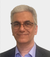

In [3]:
base_width = 50
w_percent = (base_width / float(image.size[0]))
h_size = int((float(image.size[1]) * float(w_percent)))
resized_image = image.resize((base_width, h_size), Image.Resampling.LANCZOS)

display(resized_image)

## modifying model config to support new vision model 

In [ ]:
qformer_config

{'dim': 1152,
 'heads': 8,
 'depth': 8,
 'dropout': 0.1,
 'text_block_depth': 2,
 'img_text_block_depth': 2}

In [18]:
old_config = model.config.vision_config

In [ ]:
old_config

SmolVLMVisionConfig {
  "attention_dropout": 0.0,
  "hidden_act": "gelu_pytorch_tanh",
  "hidden_size": 1152,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 4304,
  "layer_norm_eps": 1e-06,
  "max_image_size": {
    "longest_edge": 384
  },
  "model_type": "smolvlm_vision",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 27,
  "patch_size": 14,
  "size": {
    "longest_edge": 1920
  },
  "tie_word_embeddings": false,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.54.1",
  "use_base_siglip": false
}

In [19]:
class Config:
    def __init__(self, dictionary, old_config):
        for key, value in old_config.items():
            setattr(self, key, value)
        for key, value in dictionary.items():
            setattr(self, key, value)

qformer_config_obj = Config(qformer_config, old_config.get_config_dict(model_path)[0]["vision_config"])

In [13]:
qformer_config_obj.patch_size

14

In [20]:
qformer_config["hidden_size"] = 64
qformer_config["num_query_tokens"] = 4

## swapping vision model

the commented codes below are used to check the inner dimensions of the original and new model. not removed in case further debugging is needed.

In [ ]:
old_vision_model = model.model.vision_model

In [5]:
# import torch

# batch_size = 4
# num_crops = 1
# channels = 3
# height = 100
# width = 100

# dummy_images = torch.randn(batch_size * num_crops, channels, height, width).to(device="cpu", dtype=torch.bfloat16)

# dummy_mask = None

# with torch.no_grad():
#     output = model.model.vision_model(dummy_images, patch_attention_mask=dummy_mask)

# print(f"Input shape: {dummy_images.shape}")
# print(f"Output shape: {output.last_hidden_state.shape}")

Input shape: torch.Size([4, 3, 100, 100])
Output shape: torch.Size([4, 49, 1152])


In [ ]:
model.model.vision_model = MultiCropVisionEncoder(qformer_config, 2, output_dim=1152).to("cuda:0")
model.config.vision_config = qformer_config_obj

In [ ]:
# import torch

# batch_size = 2
# num_crops = 1
# channels = 3
# height = 100
# width = 100

# dummy_images = torch.randn(batch_size * num_crops, channels, height, width).to("cpu")

# dummy_mask = None

# vision_model = model.model.vision_model
# with torch.no_grad():
#     output = vision_model(dummy_images, patch_attention_mask=dummy_mask)

# print(f"Input shape: {dummy_images.shape}")
# print(f"Output shape: {output.last_hidden_state.shape}")

In [ ]:
# prompt = "can you read this text?"
# imgs = [resized_image,resized_image,resized_image,resized_image]
# inputs = processor(
#     text=prompt,
#     images=imgs,
#     return_tensors="pt"
# ).to(model.device, torch.bfloat16)

# generated_ids = model.generate(**inputs, max_new_tokens=50)
# output = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

# print("SmolVLM Output:", output)

In [ ]:
# dummy = torch.randn(68, 3, 384,384).to(device="cuda:0", dtype=torch.bfloat16)

# model.model.vision_model(dummy).last_hidden_state.shape

## testing new model inference for errors

In [ ]:
model.device

device(type='cuda', index=0)

In [21]:
conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "url": resized_image},
            {"type": "image", "url": resized_image},
            # {"type": "image", "url": resized_image},
            # {"type": "image", "url": resized_image},
            {"type": "text", "text": "what do you see in this image."}
        ]
    }
]

inputs = processor.apply_chat_template(
    conversation,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt"
).to(model.device, dtype=torch.bfloat16)

output_ids = model.generate(**inputs, max_new_tokens=16)
generated_texts = processor.batch_decode(output_ids, skip_special_tokens=True)
generated_texts

torch.Size([34, 3, 384, 384])
torch.Size([34, 729, 1152])


['User:\n\n\n\n\n\n\n\n\n\nwhat do you see in this image.\nAssistant:']

In [28]:
model.model.vision_model

SmolVLMVisionTransformer(
  (embeddings): SmolVLMVisionEmbeddings(
    (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
    (position_embedding): Embedding(729, 1152)
  )
  (encoder): SmolVLMEncoder(
    (layers): ModuleList(
      (0-26): 27 x SmolVLMEncoderLayer(
        (self_attn): SmolVLMVisionAttention(
          (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
          (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
          (q_proj): Linear(in_features=1152, out_features=1152, bias=True)
          (out_proj): Linear(in_features=1152, out_features=1152, bias=True)
        )
        (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
        (mlp): SmolVLMVisionMLP(
          (activation_fn): PytorchGELUTanh()
          (fc1): Linear(in_features=1152, out_features=4304, bias=True)
          (fc2): Linear(in_features=4304, out_features=1152, bias=True)
        )
        (layer_norm2): Laye